# Porosity

In [5]:
import pandas as pd

porosity_df = pd.read_csv('linear_dependency.csv')

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

import numpy as np

In [9]:
x = porosity_df['d_param'].values.reshape(-1,1)
y = porosity_df['porosity_Schwarz_p'].values

x_train, y_train, x_test, y_test = train_test_split(x, y)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((15, 1), (5, 1), (15,), (5,))

In [17]:
degree = 3

x_poly = PolynomialFeatures(degree=degree).fit_transform(x)
print(x_poly.shape)
linear = LinearRegression()
linear.fit(x_poly, y)
y_pred = linear.predict(x_poly)
mse(y, y_pred)
print(linear.coef_)

(20, 4)
[ 0.         -0.06816784  0.04984266  0.01013945]


In [18]:
import matplotlib.pyplot as plt

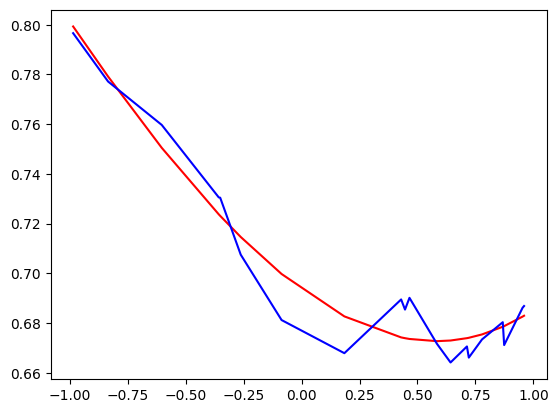

In [19]:
plt.plot(x, y_pred, c='red')
plt.plot(x, y, c='blue')

# Entropy

In [130]:
"""
! NEED TO ADD PLOT FUNCTIONAL
"""

'\n! NEED TO ADD PLOT FUNCTIONAL\n'

In [1]:
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

import numpy as np

entropy_df = pd.read_csv('entropy.csv')

- Schwarz:

        1-entropy is nice: `degree=3` or `degree=4`
        2-entropy is bad.
- Gyroid:

        1-entropy is nice: `degree 2,3,4`
        2-entropy is bad too

In [ ]:
x_train, y_train, x_test, y_test = train_test_split(x, y)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

## Polynomial

In [16]:
class PolynomialModel:
    def __init__(self, degree=4, test_size=0.33, random_state=42, round_for_poly=0.01):
        self.degree = degree
        self.model = Pipeline([('features', PolynomialFeatures(degree=degree)), 
                               ('linear', LinearRegression())])
        self.test_size = test_size
        self.random_state = random_state
        self.round_for_poly = round_for_poly

    def fit_eval(self, X_train, y_train, X_test=None, y_test=None):
        if X_test is None or y_test is None:
            X_test = X_train
            y_test = y_train

        self.model.fit(X_train, y_train)
        r_2_test = self.model.score(X_test, y_test)
        r_2_train = self.model.score(X_train, y_train)
        y_pred = self.model.predict(X_test)
        y_hat = self.model.predict(X_train)
        mse_test = mean_squared_error(y_test, y_pred)
        mse_train = mean_squared_error(y_train, y_hat)
        return {"r2_test": r_2_test, "r2_train": r_2_train, "mse_test": mse_test, "mse_train": mse_train}
    
    def return_formula(self):
        variables = self.model['features'].get_feature_names_out(['x']).tolist()
        coeffs = self.model['linear'].coef_
        coeffs_str = list(map(lambda x: str(round(x,2)), coeffs))
        polynomial = " + ".join([coef + var for coef, var in 
                                 zip(coeffs_str, variables) if np.abs(float(coef)) > self.round_for_poly])
        return f"{self.model['linear'].intercept_:.2f} + " + polynomial

In [38]:
class Experiments():
    def __init__(self, model_class, data, n_splits=4):
        self.model_class = model_class
        self.data = data
        self.n_splits=n_splits

    def _choose_values_from_list_of_dicts(self, list_of_dicts, key):
        result = [d[key] for d in list_of_dicts]
        return result

    def run_experiments(self, degrees = range(1,10), *args, **kwargs):
        kf = KFold(n_splits=self.n_splits)
        self.results = {}
        for deg in degrees:
            print(f"Current degree is {deg}")
            self.model = self.model_class(degree=deg, *args, **kwargs)
            experiment_results_list = [None] * self.n_splits
            
            for i, (train_index, test_index) in enumerate(kf.split(self.data['x'])):
                print(f"Fold {i}")
                X_train, y_train = self.data['x'][train_index,:], self.data['y'][train_index]
                X_test, y_test = self.data['x'][test_index,:], self.data['y'][test_index]
                experiment_results_for_fold = self.model.fit_eval(X_train, y_train, X_test, y_test)
                experiment_results_list[i] = experiment_results_for_fold

            experiment_results = {
                "r2_test_min": min(self._choose_values_from_list_of_dicts(experiment_results_list, "r2_test")),
                "r2_test_mean": np.mean(self._choose_values_from_list_of_dicts(experiment_results_list, "r2_test")),
                "r2_test_max": max(self._choose_values_from_list_of_dicts(experiment_results_list, "r2_test")),

                "r2_train_min": min(self._choose_values_from_list_of_dicts(experiment_results_list, "r2_train")),
                "r2_train_mean": np.mean(self._choose_values_from_list_of_dicts(experiment_results_list, "r2_train")),
                "r2_train_max": max(self._choose_values_from_list_of_dicts(experiment_results_list, "r2_train")),

                "mse_test_min": min(self._choose_values_from_list_of_dicts(experiment_results_list, "mse_test")),
                "mse_test_mean": np.mean(self._choose_values_from_list_of_dicts(experiment_results_list, "mse_test")),
                "mse_test_max": max(self._choose_values_from_list_of_dicts(experiment_results_list, "mse_test")),

                "mse_train_min": min(self._choose_values_from_list_of_dicts(experiment_results_list, "mse_train")),
                "mse_train_mean": np.mean(self._choose_values_from_list_of_dicts(experiment_results_list, "mse_train")),
                "mse_train_max": max(self._choose_values_from_list_of_dicts(experiment_results_list, "mse_train")),
            }


            self.results[deg] = experiment_results
        self.results_df = pd.DataFrame(self.results).T
        self.results_df = self.results_df.reset_index().rename(columns={"index":"degree"})

        return self.results_df

Current degree is 1
Fold 0
Fold 1
Fold 2
Fold 3
Current degree is 2
Fold 0
Fold 1
Fold 2
Fold 3
Current degree is 3
Fold 0
Fold 1
Fold 2
Fold 3
Current degree is 4
Fold 0
Fold 1
Fold 2
Fold 3
   degree  r2_test_min  r2_test_mean  r2_test_max  r2_train_min  \
0       1    -4.643708     -0.647551     0.866944      0.962102   
1       2    -6.978693     -1.255286     0.939973      0.993374   
2       3    -0.124599      0.635253     0.977002      0.999043   
3       4    -0.350729      0.356153     0.995201      0.999253   

   r2_train_mean  r2_train_max  mse_test_min  mse_test_mean  mse_test_max  \
0       0.975095      0.998666      0.008531       0.422318      1.329875   
1       0.995337      0.999160      0.037116       0.318648      0.950537   
2       0.999249      0.999609      0.001517       0.182526      0.677724   
3       0.999627      0.999835      0.002702       0.805892      3.181422   

   mse_train_min  mse_train_mean  mse_train_max  
0       0.001400        0.129597    

<Axes: title={'center': 'Gyroid'}, xlabel='degree', ylabel='MSE'>

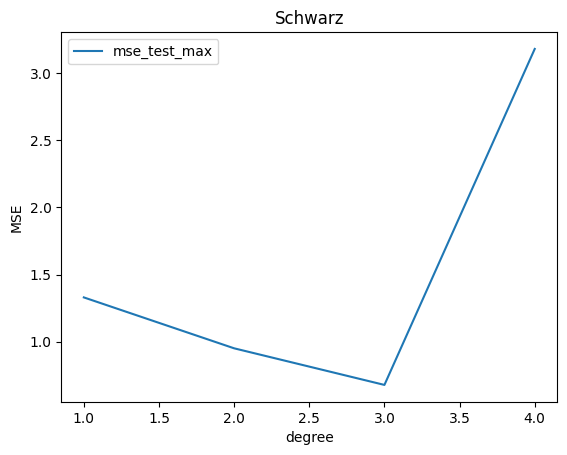

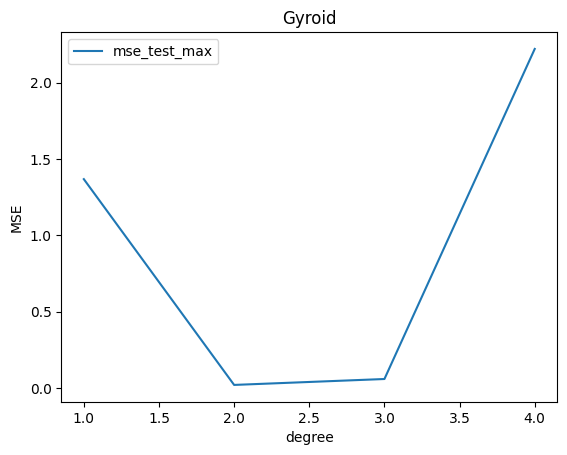

In [56]:
x = entropy_df['d_param'].values.reshape(-1,1)
data_schwarz = {'x': x, 'y': entropy_df['Schwarz'].values}
data_gyroid = {'x':x, 'y': entropy_df['Gyroid'].values}

MAX_DEG_POLYNOMIAL = 5

schwarz_polynomial_experiments = Experiments(PolynomialModel, data_schwarz)
schwarz_polynomial_metrics = schwarz_polynomial_experiments.run_experiments(degrees=range(1,MAX_DEG_POLYNOMIAL))
print(schwarz_polynomial_metrics)
schwarz_polynomial_experiments.results_df.plot("degree", "mse_test_max", ylabel='MSE', title="Schwarz")

gyroid_polynomial_experiments = Experiments(PolynomialModel, data_gyroid)
_ = gyroid_polynomial_experiments.run_experiments(degrees=range(1, MAX_DEG_POLYNOMIAL))
gyroid_polynomial_experiments.results_df.plot("degree", "mse_test_max", ylabel='MSE', title="Gyroid")

In [57]:
schwarz_polynomial_experiments.results_df

,degree,r2_test_min,r2_test_mean,r2_test_max,r2_train_min,r2_train_mean,r2_train_max,mse_test_min,mse_test_mean,mse_test_max,mse_train_min,mse_train_mean,mse_train_max
0,1,-4.643708,-0.647551,0.866944,0.962102,0.975095,0.998666,0.008531,0.422318,1.329875,0.001400,0.129597,0.195016
1,2,-6.978693,-1.255286,0.939973,0.993374,0.995337,0.999160,0.037116,0.318648,0.950537,0.000882,0.024226,0.036790
2,3,-0.124599,0.635253,0.977002,0.999043,0.999249,0.999609,0.001517,0.182526,0.677724,0.000859,0.003069,0.005313
3,4,-0.350729,0.356153,0.995201,0.999253,0.999627,0.999835,0.002702,0.805892,3.181422,0.000784,0.001166,0.001523


In [58]:
gyroid_polynomial_experiments.results_df

,degree,r2_test_min,r2_test_mean,r2_test_max,r2_train_min,r2_train_mean,r2_train_max,mse_test_min,mse_test_mean,mse_test_max,mse_train_min,mse_train_mean,mse_train_max
0,1,-26.854001,-13.642059,-0.695801,0.047150,0.258833,0.850801,0.022288,0.501868,1.368198,0.015865,0.074019,0.129841
1,2,0.822294,0.882060,0.973742,0.993384,0.996459,0.999047,0.000345,0.006210,0.020794,0.000076,0.000360,0.000559
2,3,0.493407,0.770764,0.981320,0.993588,0.996855,0.999092,0.000246,0.016277,0.059506,0.000072,0.000319,0.000554
3,4,-17.906153,-3.906216,0.978408,0.998142,0.999050,0.999845,0.000284,0.557624,2.220789,0.000017,0.000099,0.000203


In [53]:
for deg in range(1,10):
    poly_schwarz = PolynomialModel(degree=deg)
    metrics = poly_schwarz.fit_eval(data_schwarz['x'], data_schwarz['y'])
    print(f"MSE = {metrics['mse_test']:.3f}", "\t", poly_schwarz.return_formula())

MSE = 0.148 	 8.14 + -3.51x
MSE = 0.034 	 7.68 + -3.65x + 1.13x^2
MSE = 0.004 	 7.65 + -2.98x + 1.18x^2 + -1.01x^3
MSE = 0.001 	 7.74 + -2.9x + 0.47x^2 + -1.1x^3 + 0.72x^4
MSE = 0.001 	 7.74 + -2.97x + 0.45x^2 + -0.76x^3 + 0.74x^4 + -0.29x^5
MSE = 0.001 	 7.73 + -2.98x + 0.58x^2 + -0.74x^3 + 0.4x^4 + -0.3x^5 + 0.24x^6
MSE = 0.001 	 7.73 + -3.02x + 0.56x^2 + -0.38x^3 + 0.44x^4 + -1.06x^5 + 0.21x^6 + 0.46x^7
MSE = 0.000 	 7.79 + -2.97x + -0.97x^2 + -0.91x^3 + 8.53x^4 + -0.11x^5 + -13.58x^6 + 0.03x^7 + 7.3x^8
MSE = 0.000 	 7.81 + -3.29x + -1.53x^2 + 3.36x^3 + 11.5x^4 + -16.63x^5 + -18.38x^6 + 23.69x^7 + 9.65x^8 + -11.19x^9


In [54]:
for deg in range(1,10):
    poly_gyroid = PolynomialModel(degree=deg)
    metrics = poly_gyroid.fit_eval(data_gyroid['x'], data_gyroid['y'])
    print(f"MSE = {metrics['mse_test']:.3f}", "\t", poly_gyroid.return_formula())

MSE = 0.102 	 8.40 + -0.14x
MSE = 0.000 	 8.83 + -1.06x^2
MSE = 0.000 	 8.83 + -0.03x + -1.06x^2 + 0.03x^3
MSE = 0.000 	 8.86 + -1.28x^2 + 0.22x^4
MSE = 0.000 	 8.86 + -0.04x + -1.29x^2 + 0.18x^3 + 0.23x^4 + -0.15x^5
MSE = 0.000 	 8.88 + -0.03x + -1.59x^2 + 0.13x^3 + 1.03x^4 + -0.12x^5 + -0.55x^6
MSE = 0.000 	 8.88 + -0.06x + -1.6x^2 + 0.39x^3 + 1.06x^4 + -0.67x^5 + -0.56x^6 + 0.33x^7
MSE = 0.000 	 8.90 + -0.04x + -1.94x^2 + 0.27x^3 + 2.83x^4 + -0.46x^5 + -3.58x^6 + 0.24x^7 + 1.59x^8
MSE = 0.000 	 8.90 + -0.1x + -2.03x^2 + 0.97x^3 + 3.32x^4 + -3.16x^5 + -4.36x^6 + 4.1x^7 + 1.98x^8 + -1.83x^9


In [44]:
plt.plot(x, y_pred, c='red')
plt.plot(x, y_schwarz, c='blue')

NameError: name 'y_pred' is not defined

In [45]:
plt.plot(x, y_pred, c='red')
plt.plot(x, y_gyroid, c='blue')

NameError: name 'y_pred' is not defined

## Exponential

In [46]:
class ExponentialModel(PolynomialModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def fit_eval(self, X_train, y_train, X_test=None, y_test=None):
        if X_test is None or y_test is None:
            X_test = X_train
            y_test = y_train

        self.model.fit(X_train, np.log(y_train))
        y_pred = np.exp(self.model.predict(X_test))
        y_hat = np.exp(self.model.predict(X_train))
        
        return {"r2_test": r2_score(y_test, y_pred), 
                "r2_train": r2_score(y_train, y_hat), 
                "mse_test": mean_squared_error(y_test, y_pred), 
                "mse_train": mean_squared_error(y_train, y_hat)}


    def return_formula(self):
        variables = self.model['features'].get_feature_names_out(['x']).tolist()
        coeffs = self.model['linear'].coef_
        coeffs_str = list(map(lambda x: str(round(x,2)), coeffs))
        polynomial = " + ".join([coef + var for coef, var in 
                                 zip(coeffs_str, variables) if np.abs(float(coef)) > self.round_for_poly])
        return f"{np.exp(self.model['linear'].intercept_):.2f} * " + f"exp({polynomial})"

Current degree is 1
Fold 0
Fold 1
Fold 2
Fold 3
Current degree is 2
Fold 0
Fold 1
Fold 2
Fold 3
Current degree is 3
Fold 0
Fold 1
Fold 2
Fold 3
Current degree is 4
Fold 0
Fold 1
Fold 2
Fold 3
Current degree is 5
Fold 0
Fold 1
Fold 2
Fold 3
Current degree is 6
Fold 0
Fold 1
Fold 2
Fold 3
   degree   r2_test_min  r2_test_mean  r2_test_max  r2_train_min  \
0       1      0.826900      0.900115     0.982046      0.988280   
1       2     -1.500049      0.166261     0.979481      0.995527   
2       3      0.830461      0.942500     0.998490      0.999158   
3       4     -0.320308      0.586683     0.995349      0.999280   
4       5    -22.523723     -5.031788     0.995034      0.999703   
5       6 -27300.188094  -6824.334659     0.966654      0.999688   

   r2_train_mean  r2_train_max  mse_test_min  mse_test_mean  mse_test_max  \
0       0.992057      0.995637      0.004228       0.048378      0.165316   
1       0.996938      0.999105      0.014706       0.352449      1.301886   
2   

<Axes: title={'center': 'Gyroid'}, xlabel='degree', ylabel='MSE'>

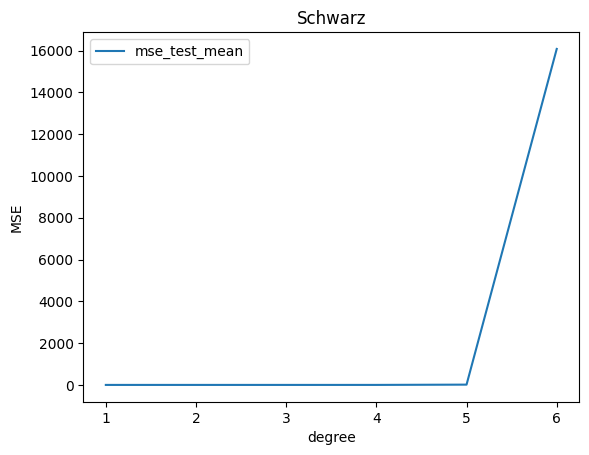

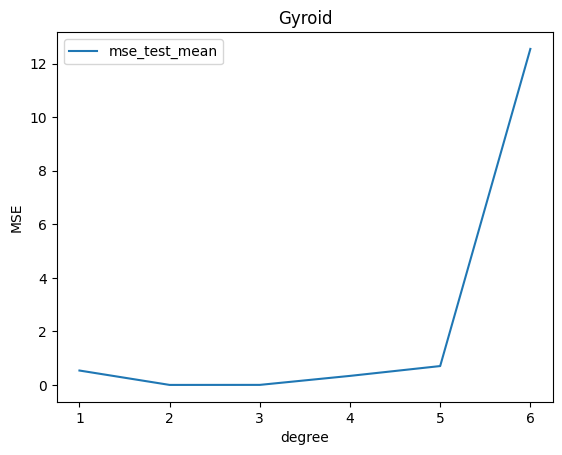

In [55]:
MAX_DEG_EXPONENTIAL = 7

schwarz_exponential_experiments = Experiments(ExponentialModel, data_schwarz)
schwarz_exponential_metrics = schwarz_exponential_experiments.run_experiments(degrees=range(1,MAX_DEG_EXPONENTIAL))
print(schwarz_exponential_metrics)
schwarz_exponential_experiments.results_df.plot("degree", "mse_test_mean", ylabel='MSE', title="Schwarz")

gyroid_exponential_experiments = Experiments(ExponentialModel, data_gyroid)
gyroid_exponential_metrics = gyroid_exponential_experiments.run_experiments(degrees=range(1,MAX_DEG_EXPONENTIAL))
print(gyroid_exponential_metrics)
gyroid_exponential_experiments.results_df.plot("degree", "mse_test_mean", ylabel='MSE', title="Gyroid")

In [48]:
schwarz_exponential_experiments.results_df

,degree,r2_test_min,r2_test_mean,r2_test_max,r2_train_min,r2_train_mean,r2_train_max,mse_test_min,mse_test_mean,mse_test_max,mse_train_min,mse_train_mean,mse_train_max
0,1,0.826900,0.900115,0.982046,0.988280,0.992057,0.995637,0.004228,0.048378,0.165316,0.004581,0.036914,0.052376
1,2,-1.500049,0.166261,0.979481,0.995527,0.996938,0.999105,0.014706,0.352449,1.301886,0.000940,0.015635,0.024836
2,3,0.830461,0.942500,0.998490,0.999158,0.999518,0.999825,0.000097,0.101713,0.399321,0.000884,0.001630,0.002580
3,4,-0.320308,0.586683,0.995349,0.999280,0.999638,0.999847,0.001737,0.781013,3.109771,0.000756,0.001137,0.001523


In [49]:
gyroid_exponential_experiments.results_df

,degree,r2_test_min,r2_test_mean,r2_test_max,r2_train_min,r2_train_mean,r2_train_max,mse_test_min,mse_test_mean,mse_test_max,mse_train_min,mse_train_mean,mse_train_max
0,1,-27.068525,-14.134904,-0.838701,0.045987,0.253799,0.837059,0.024166,0.541090,1.515273,0.017326,0.074559,0.130281
1,2,0.876702,0.932147,0.987087,0.995038,0.997414,0.999542,0.000170,0.003555,0.011870,0.000036,0.000263,0.000399
2,3,0.849552,0.915062,0.991236,0.995062,0.997595,0.999544,0.000115,0.005069,0.017672,0.000036,0.000243,0.000394
3,4,-10.537815,-2.039986,0.979960,0.998272,0.999110,0.999856,0.000263,0.340921,1.355276,0.000015,0.000092,0.000189


In [129]:
exponential_fit = np.polyfit(data_schwarz['x'].squeeze(), np.log(data_schwarz['y']), 1)
print(exponential_fit)

exponential_model_schwarz = ExponentialModel(data_schwarz, degree=1)
print(exponential_model_schwarz.fit())
print(exponential_model_schwarz.return_formula())


[-0.44803945  2.05484216]
{'r2_test': 0.9779559409671028, 'r2_train': 0.997402126059657, 'mse_test': 0.17279422973990077, 'mse_train': 0.006549034237939672}
7.72 * exp(-0.43x)


In [87]:
#fit the model
x = x.squeeze()
y_schwarz = entropy_df['Schwarz'].values

exponential_fit = np.polyfit(x, np.log(y_schwarz), 2)

#view the output of the model
print(exponential_fit)

[ 0.02566328 -0.45120541  2.04445919]


In [10]:
exp_model = np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
#np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
#np.exp(exponential_fit[0] * x + exponential_fit[1]) 
mse(y_schwarz, exp_model)

0.023703962197357497

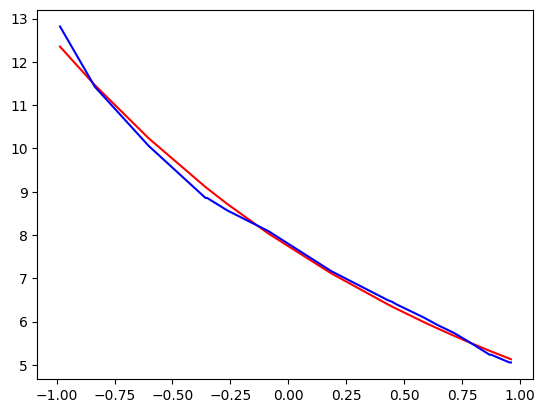

In [11]:
plt.plot(x, exp_model, c='red')
plt.plot(x, y_schwarz, c='blue')

In [12]:
y_gyroid = entropy_df['Gyroid'].values

exponential_fit = np.polyfit(x, np.log(y_gyroid), 2)
print(exponential_fit)

[-1.27552374e-01 -7.93674446e-04  2.17945386e+00]


In [13]:
exp_model = np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
#np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
#np.exp(exponential_fit[0] * x + exponential_fit[1]) 
#np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
mse(y_gyroid, exp_model)

0.0003326615654946755

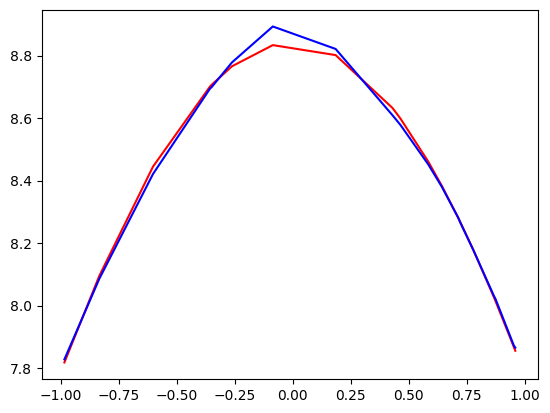

In [14]:
plt.plot(x, exp_model, c='red')
plt.plot(x, y_gyroid, c='blue')